# A/B Test Statistics

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [2]:
df = pd.read_csv("Globox_project_masterschool.csv")

In [3]:
df.head(20)

,user_id,country,gender,device_type,group_type,converted,total_spent
0,1000000,CAN,M,i_phone,Treatment,0,0.0
1,1000001,BRA,M,android,Control,0,0.0
2,1000002,FRA,M,android,Control,0,0.0
3,1000003,BRA,M,i_phone,Treatment,0,0.0
4,1000004,DEU,F,android,Control,0,0.0
5,1000005,GBR,F,android,Treatment,0,0.0
6,1000006,ESP,M,android,Treatment,0,0.0
7,1000007,BRA,F,android,Control,0,0.0
8,1000008,BRA,F,android,Control,0,0.0
9,1000009,USA,NaN,android,Control,0,0.0


In [4]:
df.shape

(48943, 7)

In [5]:
df.describe()

,user_id,converted,total_spent
count,4.894300e+04,48943.000000,48943.000000
mean,1.025001e+06,0.042784,3.382736
std,1.443521e+04,0.202373,25.674946
min,1.000000e+06,0.000000,0.000000
25%,1.012506e+06,0.000000,0.000000
50%,1.024996e+06,0.000000,0.000000
75%,1.037504e+06,0.000000,0.000000
max,1.049999e+06,1.000000,1659.400000


In [6]:
null_values = df.isnull().sum()
null_values

user_id           0
country           0
gender         6855
device_type       0
group_type        0
converted         0
total_spent       0
dtype: int64

In [7]:
df['gender'].fillna('Unknown', inplace=True)
df['gender'].replace({'O': 'Unknown', 'Unknown': 'Unknown'}, inplace=True)

In [8]:
df['gender'].value_counts()

gender
M          20289
F          20130
Unknown     8524
Name: count, dtype: int64

In [9]:
duplicates = df.duplicated().sum()
duplicates

0

In [10]:
control_df = df[df['group_type'] == 'Control']
control_df['converted'].value_counts()

converted
0    23388
1      955
Name: count, dtype: int64

In [11]:
treatment_df = df[df['group_type'] == 'Treatment']
treatment_df['converted'].value_counts()

converted
0    23461
1     1139
Name: count, dtype: int64

# Conduct a hypothesis test to see whether there is a difference in the conversion rate between the two groups. What are the resulting p-value and conclusion?

Null Hypothesis (H0):
There is no significant difference in the conversion rates between the treatment and control groups.

Alternative Hypothesis (H1):
There is a significant difference in the conversion rates between thetreatment and control groups.


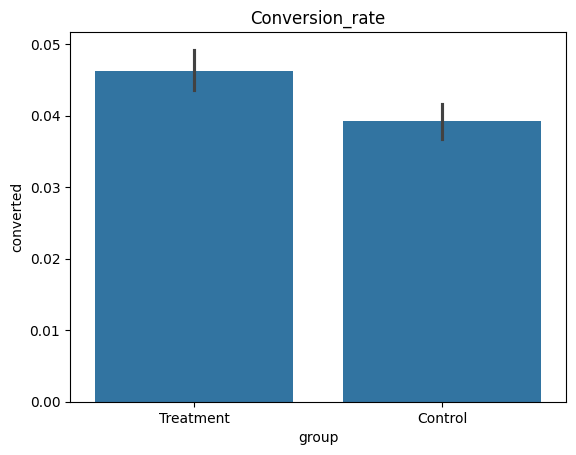

In [12]:
sns.barplot(x=df['group_type'], y=df['converted'])
plt.xlabel('group')
plt.ylabel('converted')
plt.title('Conversion_rate')
plt.show()

We are working with proportions (conversion rates), comparing two independent samples, and considering a two-sided alternative hypothesis.
Therefore, we will use a two-sample z-test for proportions

In [13]:
#lets check for the sample size
total_users = df.groupby('group_type')['user_id'].count()
total_users

group_type
Control      24343
Treatment    24600
Name: user_id, dtype: int64

In [14]:
control_converted = df[(df['group_type'] == 'Control') & (df['total_spent'] != 0)]
control_converted

,user_id,country,gender,device_type,group_type,converted,total_spent
137,1000141,BRA,M,android,Control,1,11.49
154,1000160,USA,F,android,Control,1,35.34
156,1000162,BRA,M,android,Control,1,52.92
193,1000200,USA,F,i_phone,Control,1,166.32
254,1000261,TUR,F,android,Control,1,205.98
...,...,...,...,...,...,...,...
48780,1049834,USA,F,i_phone,Control,1,160.35
48819,1049874,USA,M,i_phone,Control,1,29.89
48825,1049880,TUR,M,i_phone,Control,1,186.69
48839,1049894,BRA,F,i_phone,Control,1,34.05


In [15]:
treatment_converted = df[(df['group_type'] == 'Treatment') & (df['total_spent'] != 0)]
treatment_converted

,user_id,country,gender,device_type,group_type,converted,total_spent
38,1000039,GBR,F,android,Treatment,1,36.650000
44,1000045,USA,F,i_phone,Treatment,1,51.580000
69,1000071,USA,F,i_phone,Treatment,1,6.710000
98,1000101,MEX,F,android,Treatment,1,23.804497
119,1000123,DEU,Unknown,i_phone,Treatment,1,100.740000
...,...,...,...,...,...,...,...
48646,1049698,DEU,Unknown,i_phone,Treatment,1,92.190000
48677,1049729,USA,F,android,Treatment,1,122.730000
48714,1049766,FRA,F,android,Treatment,1,61.070000
48836,1049891,BRA,F,android,Treatment,1,47.140000


In [16]:
# Conversion rates
control_conversion_rate = (955/24343)
control_conversion_rate 

0.03923099042845993

In [17]:
treatment_conversion_rate = (1139/24600) 
treatment_conversion_rate 

0.04630081300813008

In [18]:
n1= len(treatment_df["converted"])
n2= len(control_df["converted"])
total = [treatment_converted["converted"].sum(),control_converted["converted"].sum()]
n_ab = [n1,n2]

z_stat, pval = proportions_ztest(total, nobs=n_ab,alternative = 'two-sided')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.4f}')


z statistic: 3.86
p-value: 0.0001


The Z statistic of 3.86 suggests that the observed data point is 3.86 standard deviations away from the mean. The p-value of 0.0001 is very small less than 0.05, we reject the Null Hypothesis. 
This means we would conclude that there is a significant difference in the conversion rates between the treatment and control groups. 

In [23]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    
    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [24]:
success_a = 1139
size_a = 24600
success_b = 955
size_b = 24343
prop_a = success_a / size_a
prop_b = success_b / size_b
prop_diff, confint = two_proprotions_confint(success_b, size_b, success_a, size_a)
print('estimate difference:', prop_diff)
print('confidence interval:', confint)

estimate difference: 0.0070698225796701555
confidence interval: [0.00348605 0.01065359]


Here estimate difference indicates that on average, the conversion rate in the treatment group is estimated to be 0.00707 units higher than the conversion rate in the control group. 
And confidence interval indicates that you can be 95% confident that the true difference in conversion rates between the treatment and control groups is somewhere between 0.00348605 and 0.01065359.

# Conduct a hypothesis test to see whether there is a difference in the average amount spent per user between the two groups. What are the resulting p-value and conclusion?

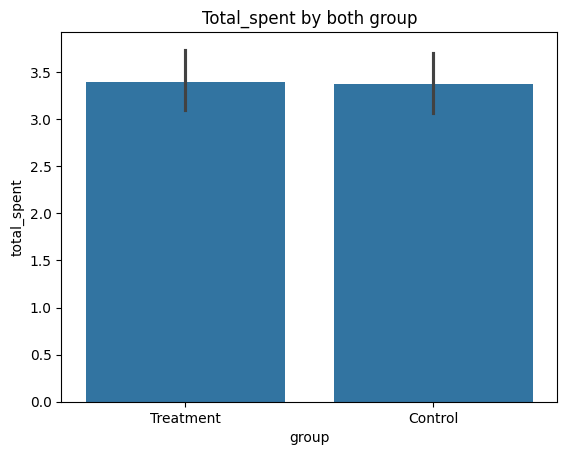

In [25]:
sns.barplot(x=df['group_type'], y=df['total_spent'])
plt.xlabel('group')
plt.ylabel('total_spent')
plt.title('Total_spent by both group')
plt.show()

In [26]:
control_df.describe()

,user_id,converted,total_spent
count,2.434300e+04,24343.000000,24343.000000
mean,1.025020e+06,0.039231,3.374518
std,1.446357e+04,0.194148,25.936391
min,1.000001e+06,0.000000,0.000000
25%,1.012468e+06,0.000000,0.000000
50%,1.025045e+06,0.000000,0.000000
75%,1.037592e+06,0.000000,0.000000
max,1.049996e+06,1.000000,1659.400000


In [27]:
treatment_df.describe()

,user_id,converted,total_spent
count,2.460000e+04,24600.000000,24600.000000
mean,1.024982e+06,0.046301,3.390867
std,1.440737e+04,0.210140,25.414110
min,1.000000e+06,0.000000,0.000000
25%,1.012534e+06,0.000000,0.000000
50%,1.024953e+06,0.000000,0.000000
75%,1.037413e+06,0.000000,0.000000
max,1.049999e+06,1.000000,1546.300000


Null Hypothesis (H0): There is no significant difference in the average amount spent per user  between the treatment and control groups.

Alternative Hypothesis (H1): There is a significant difference in the average amount spent per user  between the treatment and control groups.

In [28]:
c_df = control_df["total_spent"]

In [29]:
t_df = treatment_df["total_spent"]

In [30]:
t_statistic, p_value = ttest_ind(t_df,c_df)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.07043243220818624
P-value: 0.9438497659410892


A higher p-value, such as 0.9438, suggests weak evidence against the null hypothesis. So here we are fail to reject Null hypothesis. This means we would conclude that there is a significant difference in the average amount spent per user between the treatment and control groups.

What is the 95% confidence interval for the difference in the average amount spent per user between the treatment and the control (treatment-control)?

In [90]:
import pingouin as pg

In [93]:
res = pg.ttest(c_df,t_df,paired=False)
print(res)

               T           dof alternative     p-val          CI95%   cohen-d  \
T-test -0.070425  48894.497311   two-sided  0.943856  [-0.47, 0.44]  0.000637   

        BF10     power  
T-test  0.01  0.050568  


95% confidence interval  = [-0.47, 0.44]

# Check for Novelty Effects

In [94]:
df.groupby(["group_type"])["total_spent"].mean()

group_type
Control      3.374518
Treatment    3.390867
Name: total_spent, dtype: float64

In [95]:
df.groupby(["group_type","device_type"])["converted"].value_counts()

group_type  device_type  converted
Control     android      0            14637
                         1              417
            i_phone      0             8607
                         1              535
            other        0              144
                         1                3
Treatment   android      0            14698
                         1              537
            i_phone      0             8622
                         1              596
            other        0              141
                         1                6
Name: count, dtype: int64

In [96]:
df.groupby(["group_type","device_type"])["total_spent"].mean()

group_type  device_type
Control     android        2.312639
            i_phone        5.072231
            other          6.538095
Treatment   android        2.465895
            i_phone        4.918564
            other          3.456487
Name: total_spent, dtype: float64

In [97]:
df.groupby(["group_type","device_type"])["total_spent"].sum()

group_type  device_type
Control     android        34814.470516
            i_phone        46370.332548
            other            961.100000
Treatment   android        37567.903211
            i_phone        45339.320053
            other            508.103605
Name: total_spent, dtype: float64

In [98]:
df.groupby(["group_type"])["converted"].value_counts()

group_type  converted
Control     0            23388
            1              955
Treatment   0            23461
            1             1139
Name: count, dtype: int64

there are several ways we can correct for novelty effects when detected in our test. The first way is to increase the test duration until we see the metrics converge to stable levels. Additionally, we can examine the results of new and returning user cohorts separately. If novelty effects exist, we can expect new users who are seeing either the control or treatment variants for the first time to have the cleanest data, whereas returning users may experience novelty effects or change aversion as they are inherently comparing their default experience to the new one.

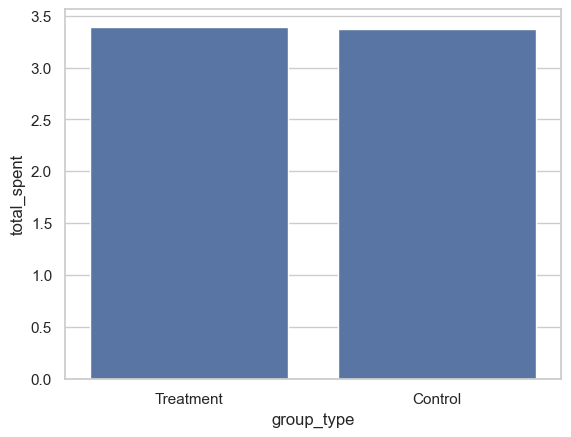

In [99]:
sns.barplot(data=df, x='group_type', y='total_spent', errorbar=None)
plt.show()

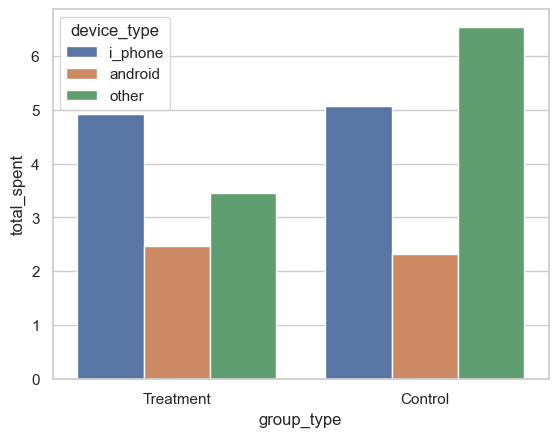

In [100]:
sns.barplot(data=df, x='group_type', y='total_spent', hue='device_type', errorbar=None)
plt.show()

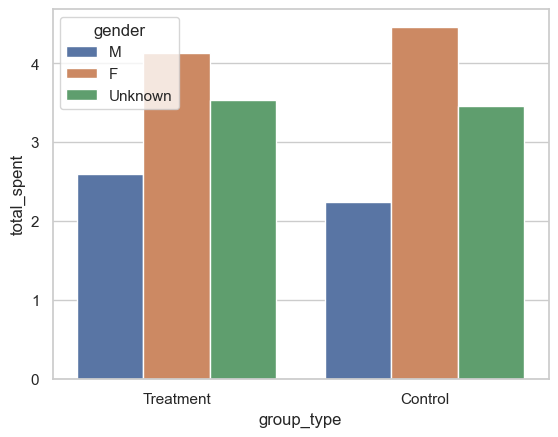

In [101]:
sns.barplot(data=df, x='group_type', y='total_spent', hue='gender', errorbar=None)
plt.show()

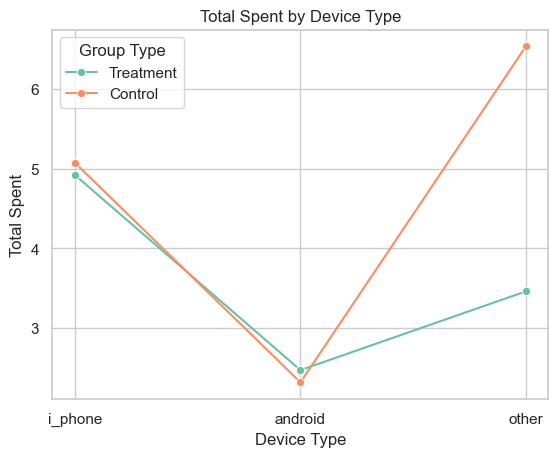

In [102]:
sns.set(style="whitegrid")
sns.lineplot(x='device_type', y='total_spent', hue='group_type', data=df, marker='o', palette='Set2',errorbar=None)
plt.xlabel('Device Type')
plt.ylabel('Total Spent')
plt.title('Total Spent by Device Type')
plt.legend(title='Group Type')
plt.show()

# Power Analysis

# Sample Size for Comparing Two Independent Means

In [155]:
pooled_sd  = np.sqrt(((25.936391)**2 + (25.414110)**2) / 2)
pooled_sd

25.676578483094094

In [131]:
#difference in mean:
3.390867-3.374518

0.016348999999999947

Assuming a pooled standard deviation of 25.674946 units, the study would require a sample size of:

38714563
for each group (i.e. a total sample size of 77429126, assuming equal group sizes), to achieve a power of 80% and a level of significance of 5% (two sided), for detecting a true difference in means between the test and the reference group of 0.016348999999999947 units.

In other words, if you select a random sample of 38714563 from each population, and determine that the difference in the two means is 0.016348999999999947 units, and the pooled standard deviation is 25.674946 units, you would have 80% power to declare that the two groups have significantly different means, i.e. a two sided p-value of less than 0.05.

# Sample Size for Comparing conversion rates

The Minimum Detectable Effect (MDE) is calculated as the sum of the baseline proportion and the desired difference:

Baseline proportion(control group conversion rate) = 0.0392(3.92%)

Desired Difference in Proportions is 0.007 (or 0.7%)

MDE (%) =Baseline Proportion (%)+ Desired Difference (%)
MDE (%)=Baseline Proportion (%)+Desired Difference (%)

MDE (%)=3.92%+0.7%=4.62%

Baseline Conversion Rate (%): 3.92%
Minimum Detectable Effect (%): 4.62%
A/B Split Ratio: 0.5 (equal group sizes)
Significance (α): 0.05 

Statistical Power (1 - β): 0.8 (the probability of correctly rejecting a false null hypothesis)

Test Size: 180.1k
Control Size: 180.1k
Total Sample Size: 360.2k

https://www.statsig.com/calculator?mde=4.62&bcr=3.9230990428459926&twoSided=true&splitRatio=0.5&alpha=0.05&power=0.8

In evaluating the sample sizes for comparing two independent means and conversion rates, it was determined that the study lacked sufficient sensitivity. For the comparison of means, assuming a pooled standard deviation of 25.674946 units, a sample size of 38714563 for each group, totaling 77429126, is recommended to achieve 80% power at a 5% significance level, detecting a true difference of 0.016348999999999947 units. Similarly, for comparing conversion rates, considering a baseline rate of 3.92% and a desired difference of 0.7%, a total sample size of 360.2k, evenly split between test and control groups, is advised to attain a statistical power of 80% at a 5% significance level. 